In [1]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

def invalid_smiles_map(product):
    mol = Chem.MolFromSmiles(product)
    atom_maps = []
    for i, atom in enumerate(mol.GetAtoms()):
        atom_map = atom.GetAtomMapNum()
        if atom_map == 0 or atom_map in atom_maps:
            return True
        else:
            atom_maps.append(atom_map)
    return False

def Tanimoto_Sim(mol1, mol2, radius = 2):
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

def contain_confusing_reagent(reactants, product):
    atom_mapping_pattern = r'\[[A-Za-z0-9\+\-]+:\d+\]'
    product_mol = Chem.MolFromSmiles(product)
    for reactant in reactants.split('.'):
        reactant_mol = Chem.MolFromSmiles(reactant)
        if not re.search(atom_mapping_pattern, reactant) and Tanimoto_Sim(reactant_mol, product_mol) >= 0.5:
            return True
    return False

In [2]:
df = pd.read_csv('raw_data.csv')

problematic_rxns = {'invalid product map': [], 'confusing reagent': []}
problematic_list = []
invalid_product_cnt = 0
confusing_reagent_cnt = 0
problematic_cnt = 0
for i, rxn in tqdm(enumerate(df['mapped_rxn']), total=len(df)):
    reactants, products = rxn.split('>>')
    if invalid_smiles_map(products):
        problematic_rxns['invalid product map'].append(rxn)
        problematic_list.append('invalid product map')
        invalid_product_cnt += 1
        problematic_cnt += 1
        continue
    if contain_confusing_reagent(reactants, products):
        problematic_rxns['confusing reagent'].append(rxn)
        problematic_list.append('confusing reagent')
        confusing_reagent_cnt += 1
        problematic_cnt += 1
    else:
        problematic_list.append('none')
print ('# of problematic reactions: %d (invalid product: %d, confusing reagent: %d)' % (problematic_cnt, invalid_product_cnt, confusing_reagent_cnt))

100%|██████████████████████████████████████████████████████████████████████████| 49996/49996 [00:45<00:00, 1106.65it/s]

# of problematic reactions: 1166 (invalid product: 347/confusing reagent: 819)


In [7]:
def show_mols(rxns):
    return Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for rxn in rxns for smi in rxn.split('>>')], molsPerRow=2, subImgSize=(400, 400))

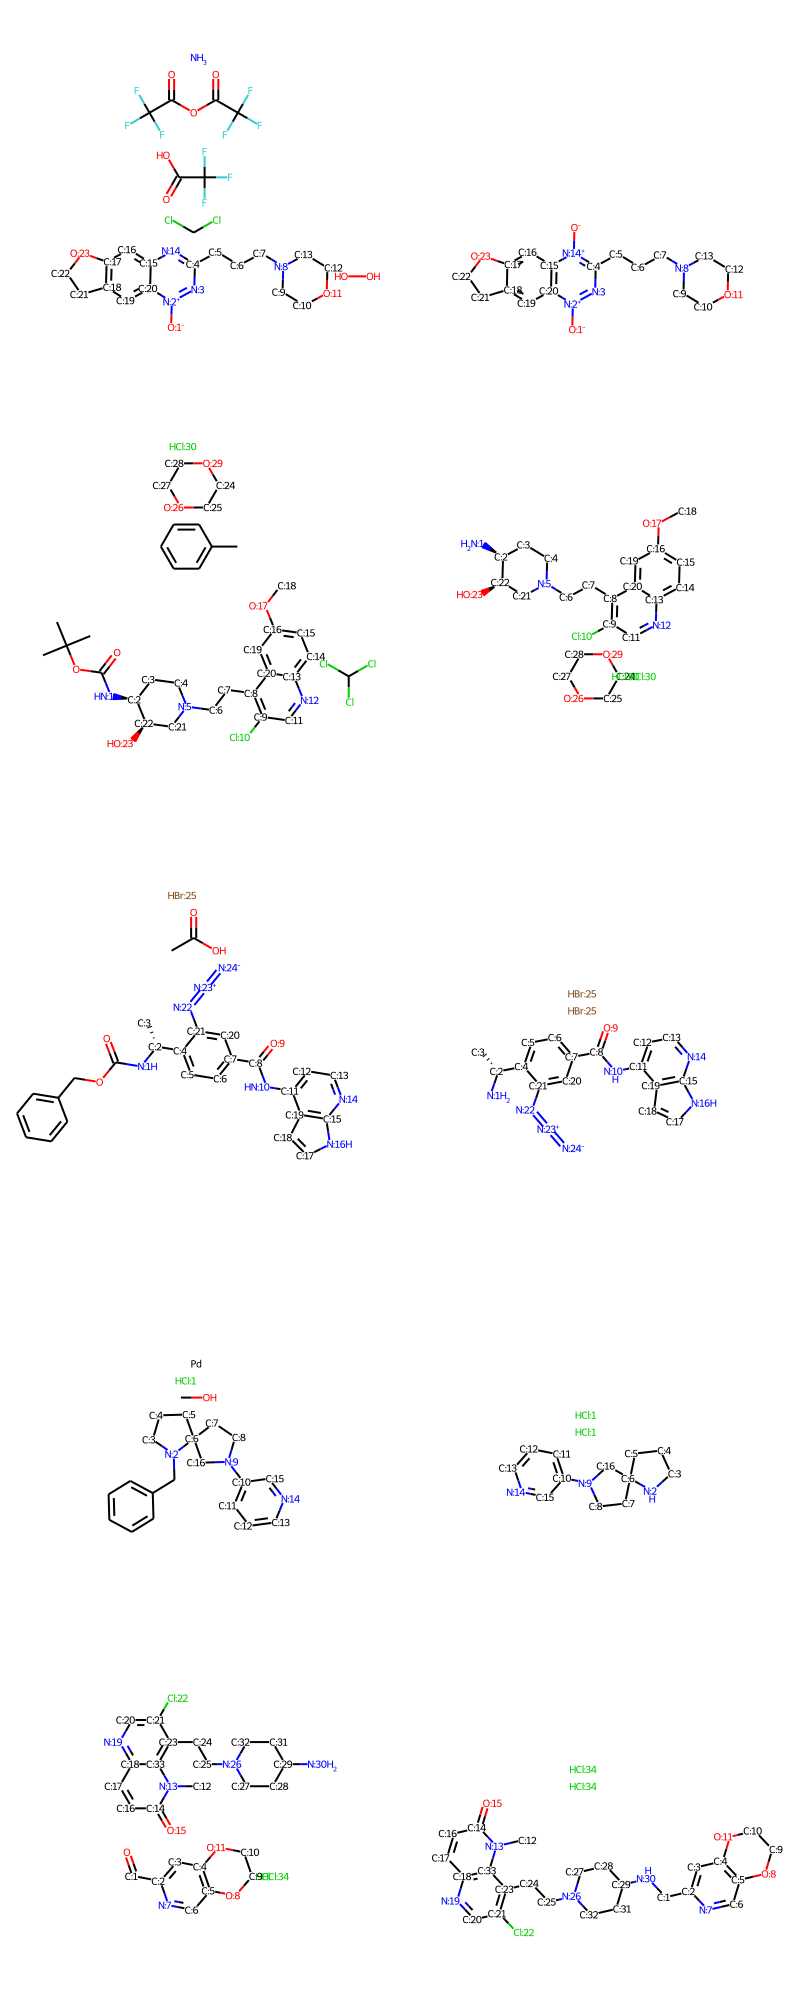

In [9]:
problem = 'invalid product map'
rxns = np.random.choice(problematic_rxns[problem], 5)
show_mols(rxns)

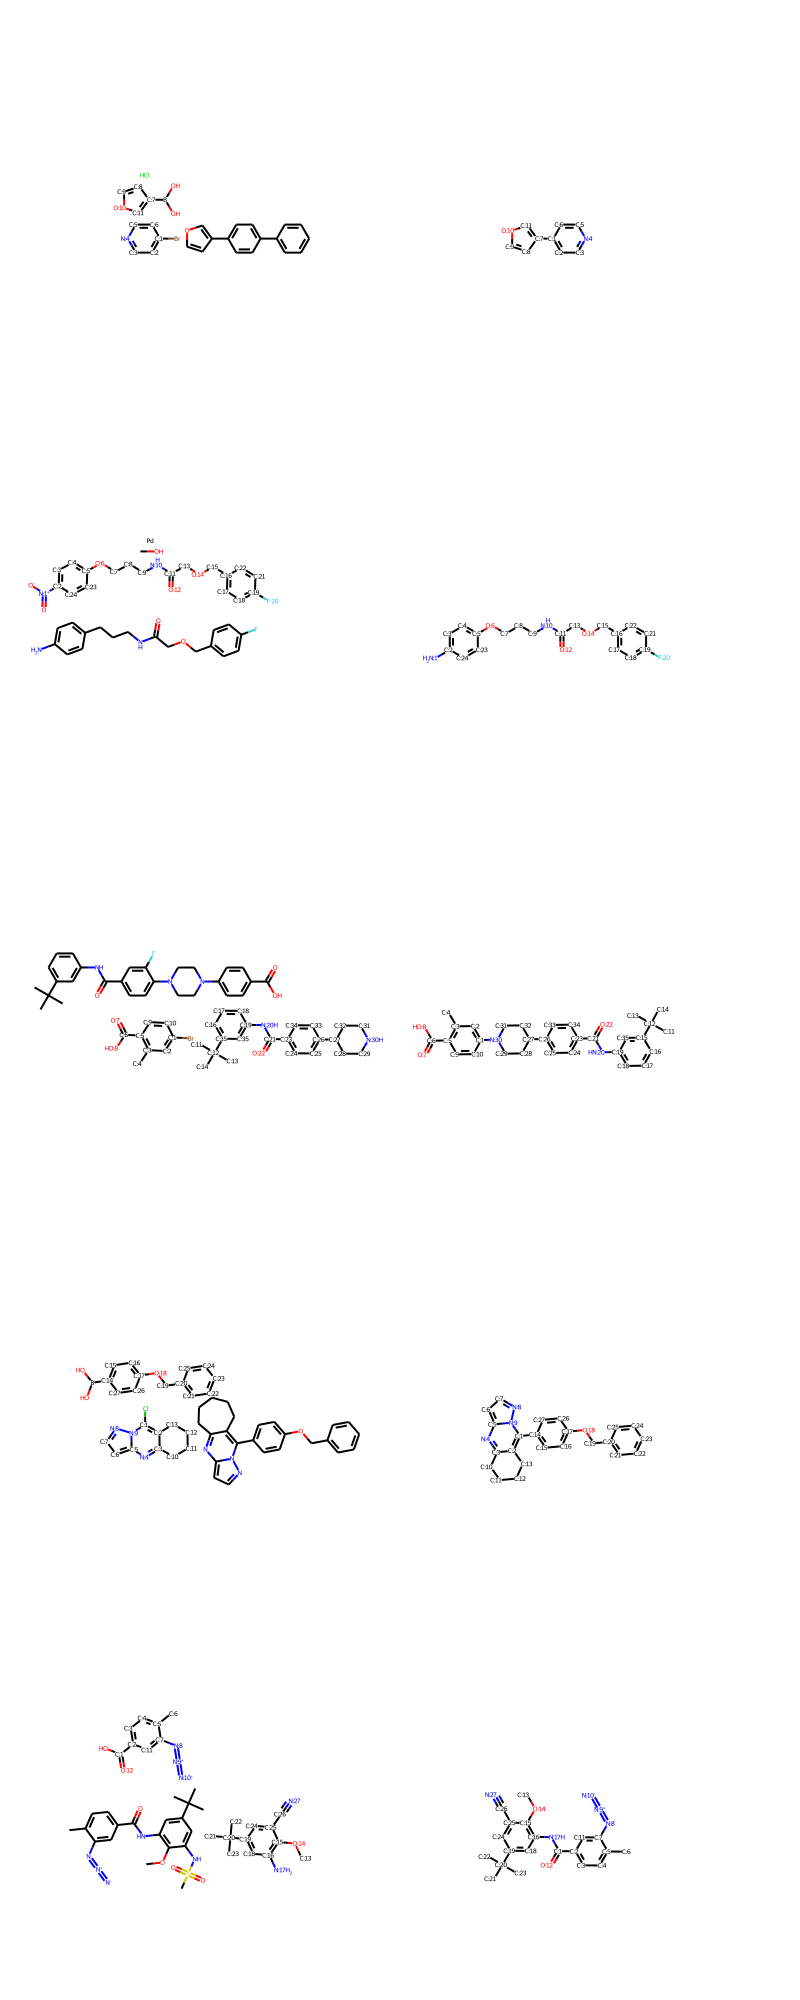

In [10]:
problem = 'confusing reagent'
rxns = np.random.choice(problematic_rxns[problem], 5)
show_mols(rxns)